In [16]:
%matplotlib inline
import sys
sys.path.append('../../')
import warnings
warnings.filterwarnings("ignore")
from pyVPRM.lib.fancy_plot import *
from rioxarray import merge
import numpy as np
import os
import glob
import xarray as xr
import shutil
import cartopy.crs as ccrs
import geopandas as gpd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from IPython.display import display

# Merge Splits

In [7]:
base_theo =  './out/'
for fbase in np.unique([i.split('_part')[0] for i in glob.glob(os.path.join(base_theo, 'VPRM_input*part_*'))]):
    print(fbase)   
    if os.path.exists(fbase+'.nc'):
        continue
#    if os.path.exists(fbase+'.nc'):
#        os.remove(fbase+'.nc')
    lon_stripes = []
    for i in [1]:
        files = sorted(glob.glob(fbase+'*{}.nc'.format(i)))
        try: 
            lon_stripes.append(xr.concat([xr.open_dataset(i).drop_dims(['x_b', 'y_b']) for i in files],
                                   dim ='west_east', compat='no_conflicts'))
        except:
            lon_stripes.append(xr.concat([xr.open_dataset(i) for i in files],
                                   dim ='west_east', compat='no_conflicts'))
        if not os.path.exists(os.path.join(base_theo,'splits')):
            os.makedirs(os.path.join(base_theo, 'splits'))
        for file in files:
            shutil.move(file, os.path.join(base_theo, 'splits', os.path.basename(file)))
    full = xr.concat(lon_stripes,dim ='south_north')
    print(fbase+'.nc')

    full.to_netcdf(fbase+'.nc')


./out/VPRM_input_EVI_2022
./out/VPRM_input_EVI_2022.nc


# Make Control Plots

In [8]:
base_path =  './out/'
t_file_fra = 'VPRM_input_VEG_FRA_2022.nc'
t_file_evi = 'VPRM_input_EVI_2022.nc'

in_theo = xr.open_dataset(os.path.join(base_path, t_file_evi))
in_theo_veg_frac = xr.open_dataset(os.path.join(base_path, t_file_fra))


## Vegetation Fraction

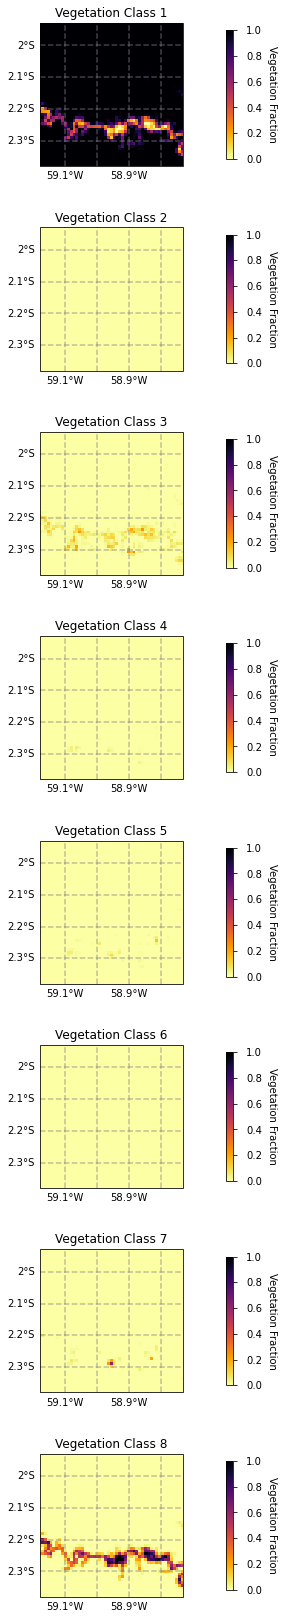

In [17]:
# define the bins and normalize
cmap = plt.cm.inferno_r
cmaplist = [cmap(i) for i in range(cmap.N)]
# cmaplist[0] = '#c4c4c4'
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(0, 1, 11)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig = plt.figure(111, figsize = figsize(0.9, ratio=5))
for c,i in enumerate(np.arange(1,9)[::-1]):
    ax = fig.add_axes((0,c*0.1+0.04,1.0, 0.07), projection=ccrs.PlateCarree())
    cb= in_theo_veg_frac.sel({'vprm_classes': i})['vegetation_fraction_map'].plot.pcolormesh(cmap=cmap, ax=ax,
                                                                             x='lon', y='lat', vmin=0, vmax=1.0,
                                                                             add_colorbar=False)
    ax.set_title('Vegetation Class {}'.format(i))
    # world.boundary.plot(ax=ax, transform=ccrs.PlateCarree(),
    #                     color='k',lw=1.)
    lats = in_theo_veg_frac['lat'].values.flatten()
    lons = in_theo_veg_frac['lon'].values.flatten()
    ax.set_xlim(np.min(lons), np.max(lons))
    ax.set_ylim(np.min(lats), np.max(lats))
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1.5, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    axins = inset_axes(ax,
                       width="5%",  
                       height="90%",
                       loc='center right',
                       borderpad=-5
                       )
    cbar = fig.colorbar(cb, cax=axins)
    cbar.ax.get_yaxis().labelpad = 15
    cbar.ax.set_ylabel('Vegetation Fraction', rotation=270)

fig.show()

## EVI / LSWI

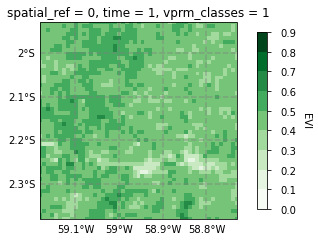

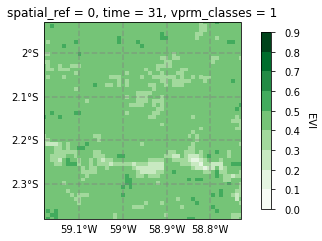

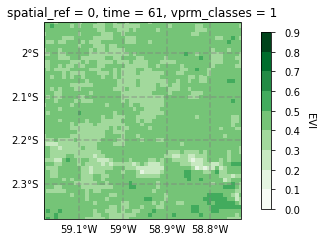

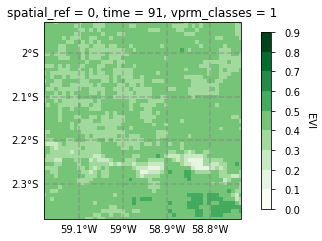

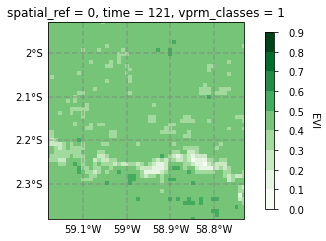

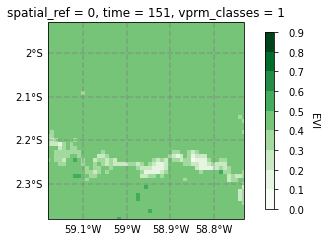

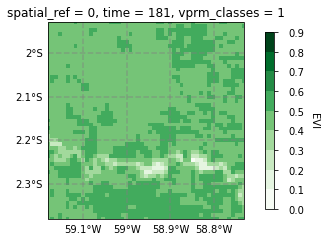

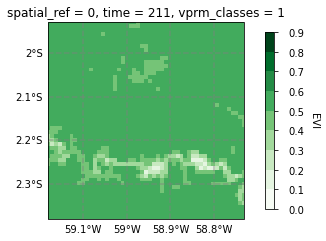

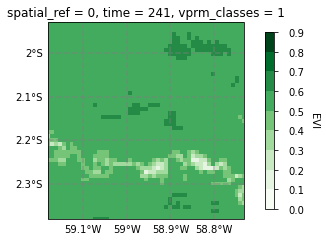

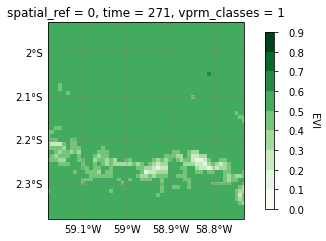

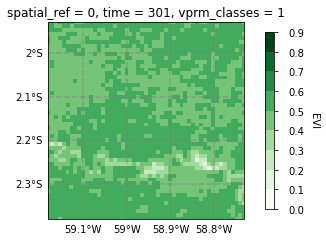

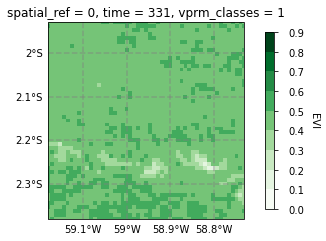

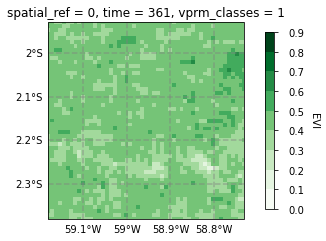

<Figure size 317.927x196.49 with 0 Axes>

In [18]:
vprm_class = 1

cmap = plt.cm.Greens
cmaplist = [cmap(i) for i in range(cmap.N)]
# cmaplist[0] = '#c4c4c4'
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(0, 0.9, 10)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

for ti in in_theo.coords['time'][0:365:30]:
    fig = plt.figure(111, figsize = figsize(0.7))
    ax = fig.add_axes((0.0, 0.0, 1.0, 1.0),
                      projection=ccrs.PlateCarree())
    t = in_theo.sel({'vprm_classes': vprm_class, 'time':ti})['evi']
    cb = t.plot.pcolormesh(y='lat', x='lon', cmap=cmap, norm=norm, 
                          add_colorbar=False)
    # world.boundary.plot(ax=ax, transform=ccrs.PlateCarree(), color='k',lw=1.)
    lats = in_theo['lat'].values.flatten()
    lons = in_theo['lon'].values.flatten()
    ax.set_xlim(np.min(lons), np.max(lons))
    ax.set_ylim(np.min(lats), np.max(lats))
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                     linewidth=1.5, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    axins = inset_axes(ax,
                       width="5%",  
                       height="90%",
                       loc='center right',
                       borderpad=-3
                       )
    cbar = fig.colorbar(cb, cax=axins)
    cbar.ax.get_yaxis().labelpad = 15
    cbar.ax.set_ylabel('EVI', rotation=270)
    display(fig)
    fig.show()
    plt.clf()